This notebook is for playing around with the Weighted Reservoir Sampling irrespective of complex images.

In [1]:
%run src/foveation_utils.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


from typing import Dict, List, Tuple

from src.reservoir import Reservoir, combine_reservoirs


In [2]:
witcher_lakeside_512_rgb  = cv2.imread("input/games/images/lakeside-villa-witcher3-512_1.png", cv2.IMREAD_COLOR)
witcher_lakeside_512_grayscale = cv2.cvtColor(witcher_lakeside_512_rgb, cv2.COLOR_BGR2GRAY)
witcher_lakeside_512_lab = cv2.cvtColor(witcher_lakeside_512_rgb, cv2.COLOR_BGR2LAB)
witcher_lakeside_512_rgb_channels = cv2.split(witcher_lakeside_512_rgb)
witcher_lakeside_512_lab_channels = cv2.split(witcher_lakeside_512_lab)

rgb_colours = ('b', 'g', 'r')

center = (witcher_lakeside_512_rgb.shape[0] // 2, witcher_lakeside_512_rgb.shape[1] // 2)
radii = (100, 200)
(width, height, _) = witcher_lakeside_512_rgb.shape

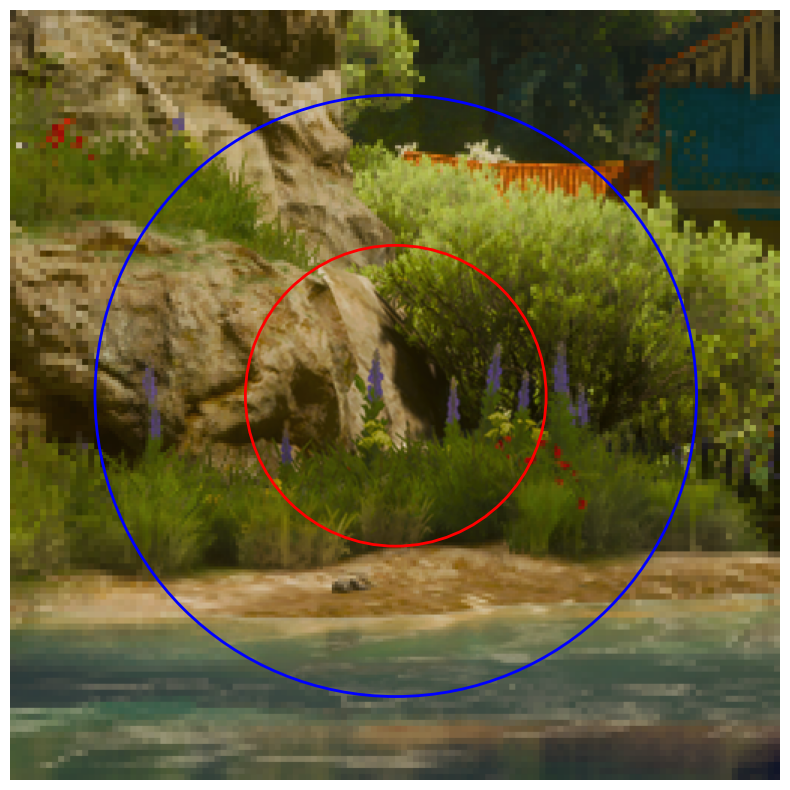

In [3]:
foveated_witcher_lakeside_512_rgb = guenter_foveated_rendering_px_mip(witcher_lakeside_512_rgb, center, radii)

visualize_guenter_foveated_regions_px(foveated_witcher_lakeside_512_rgb, center, radii)



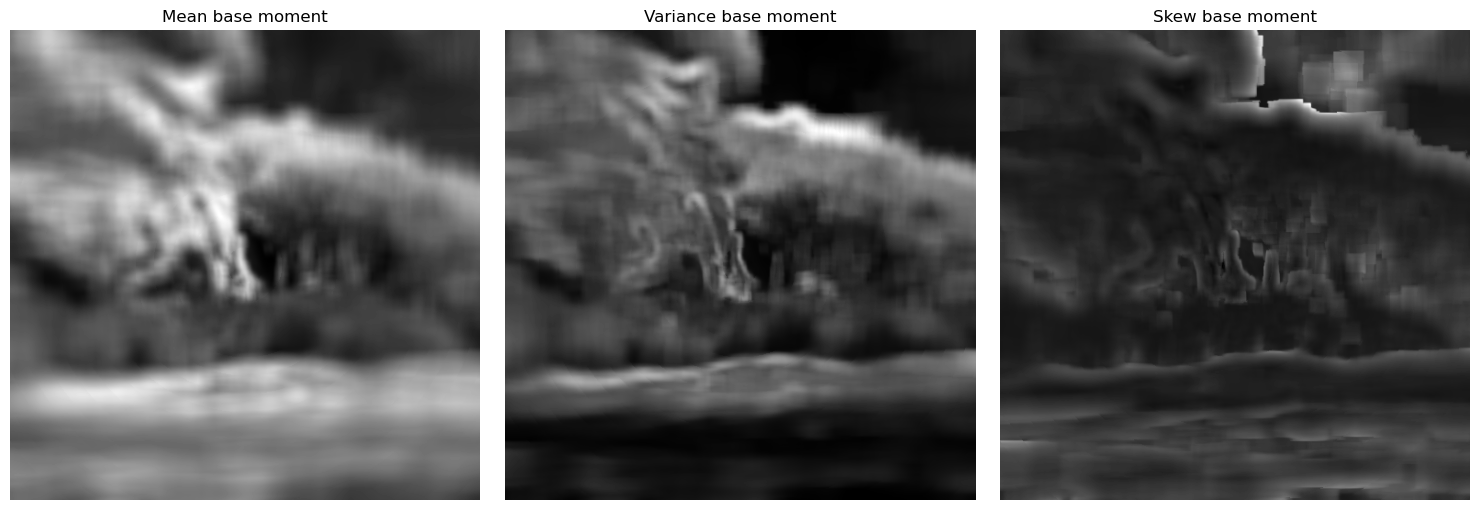

In [4]:
(mean_texture_witcher_lakeside, variance_texture_witcher_lakeside, skew_texture_witcher_lakeside) = compute_base_moments(witcher_lakeside_512_rgb, center, 0.1, base_pooling_size = 8)
visualize_base_moments(mean_texture_witcher_lakeside, variance_texture_witcher_lakeside, skew_texture_witcher_lakeside)

In [5]:
%run src/foveation_utils.py
num_levels = 5
gaussian_pyramids = compute_basemoments_gaussian_pyramids(mean_texture_witcher_lakeside, variance_texture_witcher_lakeside, skew_texture_witcher_lakeside, num_levels)
laplacian_pyramids = compute_basemoments_laplacian_pyramids(gaussian_pyramids)

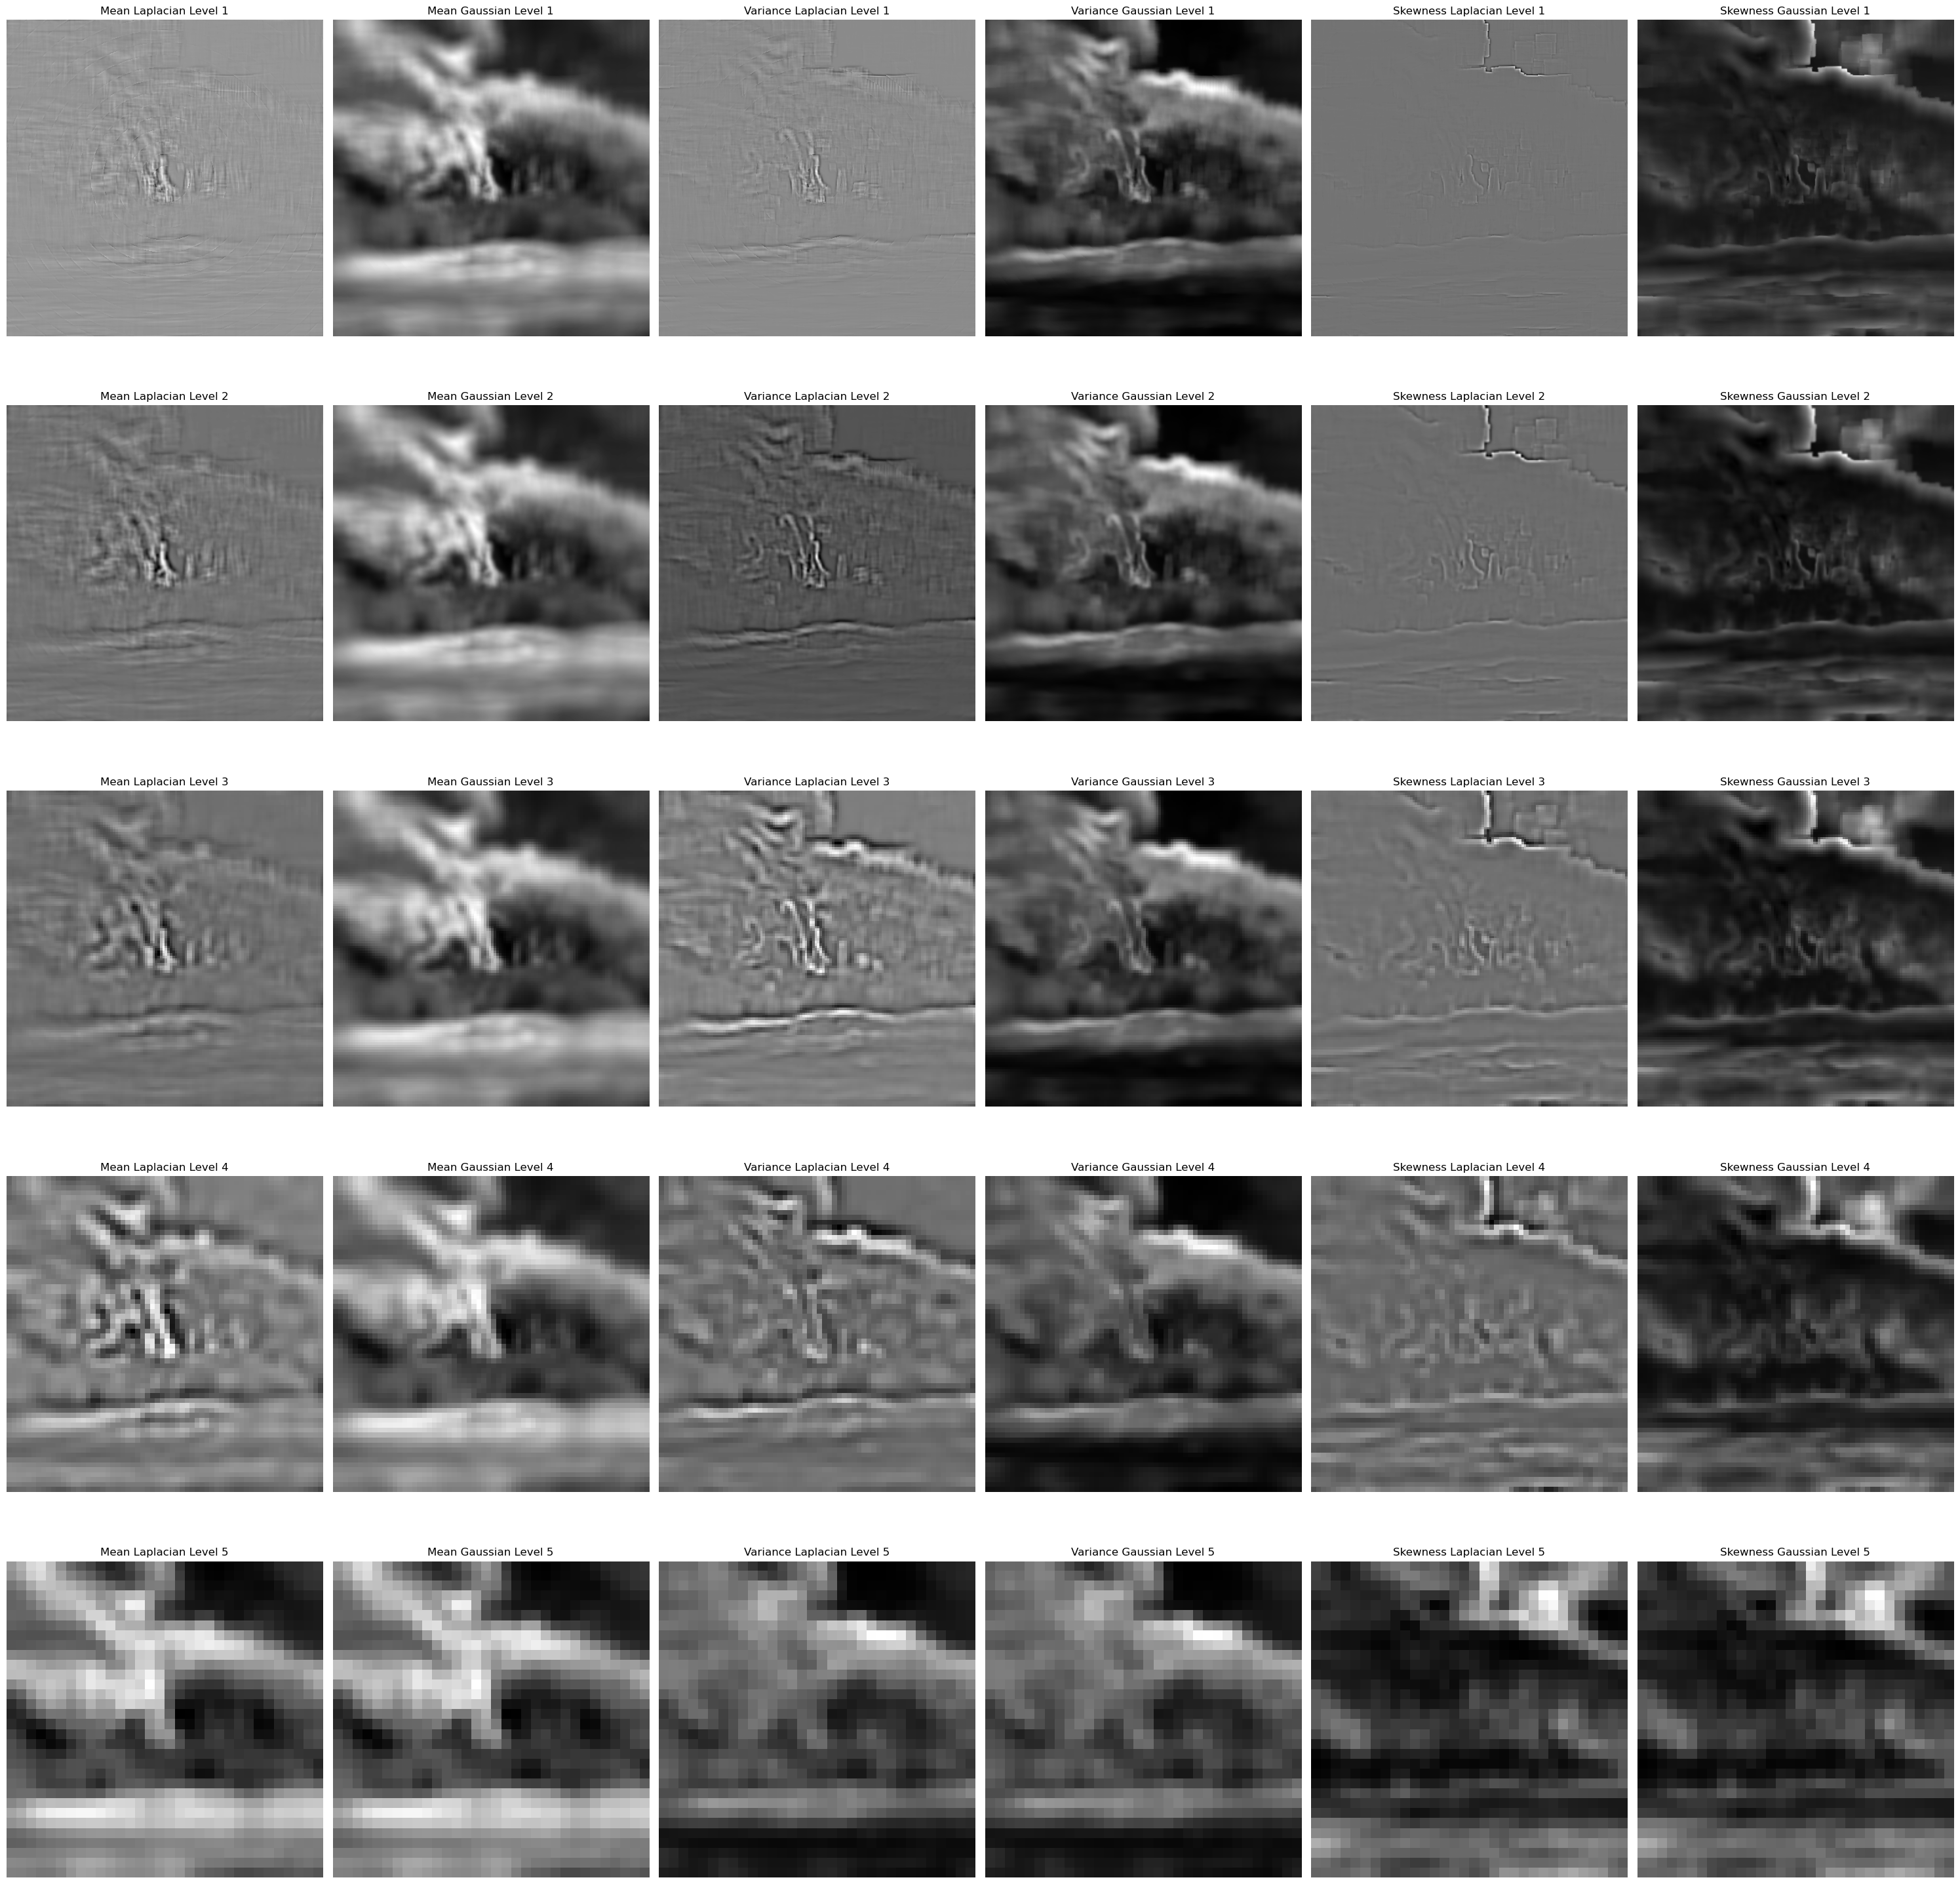

In [6]:
fig, axes = plt.subplots(num_levels, 6, figsize=(30, 30))
for i in range(num_levels):
    axes[i, 0].imshow(cv2.normalize(laplacian_pyramids['mean'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 0].set_title(f'Mean Laplacian Level {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cv2.normalize(gaussian_pyramids['mean'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 1].set_title(f'Mean Gaussian Level {i+1}')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(cv2.normalize(laplacian_pyramids['variance'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 2].set_title(f'Variance Laplacian Level {i+1}')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(cv2.normalize(gaussian_pyramids['variance'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 3].set_title(f'Variance Gaussian Level {i+1}')
    axes[i, 3].axis('off')

    axes[i, 4].imshow(cv2.normalize(laplacian_pyramids['skew'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 4].set_title(f'Skewness Laplacian Level {i+1}')
    axes[i, 4].axis('off')

    axes[i, 5].imshow(cv2.normalize(gaussian_pyramids['skew'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 5].set_title(f'Skewness Gaussian Level {i+1}')
    axes[i, 5].axis('off')

plt.tight_layout()
plt.show()

Now for the reservoir experiments. We could try building the reservoir for the first frame, which is just a storage of the first set of pixels rendered. For simplicity, I'll start by doing it based off Guenter, as in the TextStatisticsPlayground notebook. After that, it might be worth trying a per-pyramid reservoir, and then trying to combine to use the *best* reservoirs?

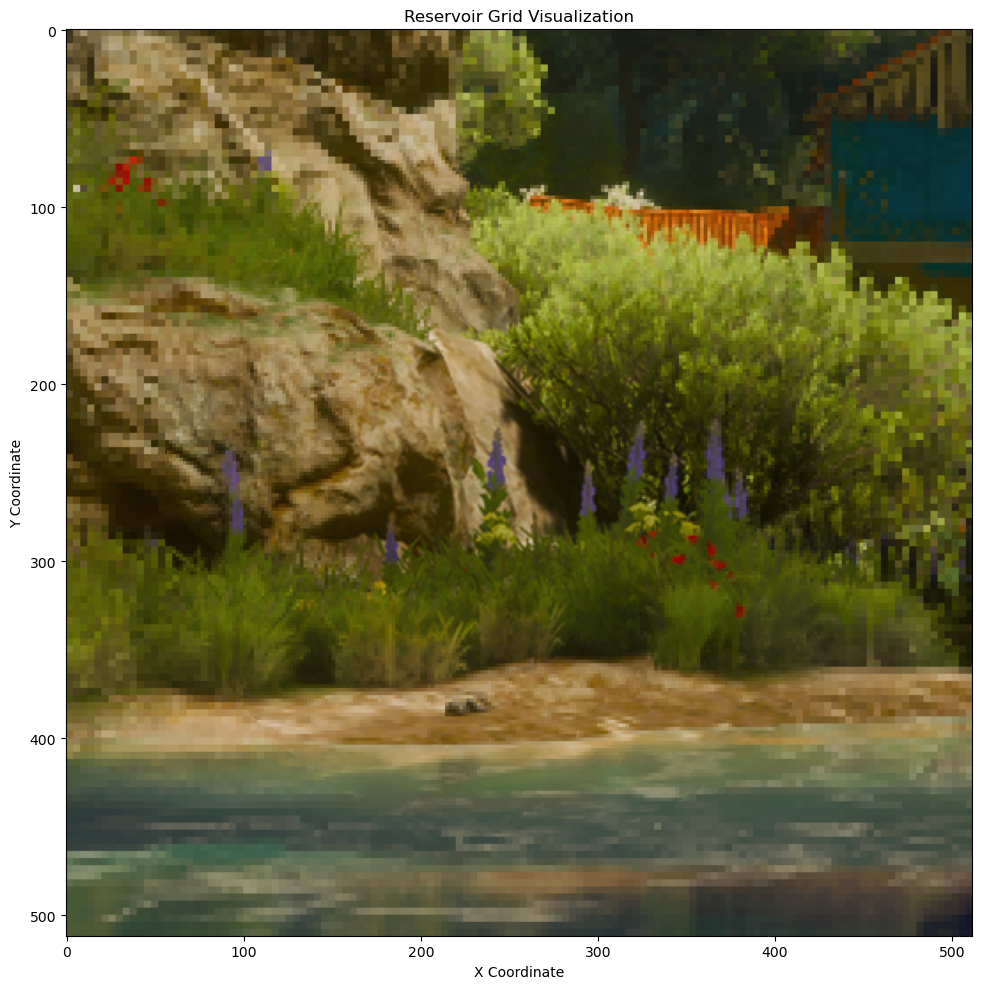

In [7]:
%run src/reservoir.py
thresholds = [50, 100, 150, 200]
start_center = (255, 255) # Unused, but represents the center used in the foveated_witcher_lakeside_512_rgb variable
centers = [(225, 225),
		   (195, 195),
		   (165, 165),
		   (135, 135), # Should show how it looks with rapid changes
		   ]


initial_reservoirs = [[Reservoir() for _ in range(width)] for _ in range(height)]


for x in range(0, width):
	for y in range(0, height):
		sample = foveated_witcher_lakeside_512_rgb[x, y]
		initial_reservoirs[x][y].update(sample, sample_weight = 0.5) # initialize reservoir weight to .5

# Show off the initial reservoir. Really, the reservoir is our image!
initial_reservoir_array = np.array([[reservoir.reservoir[0] for reservoir in row] for row in initial_reservoirs])
initial_reservoir_array = cv2.cvtColor(initial_reservoir_array, cv2.COLOR_BGR2RGB)

# Create the visualization
plt.figure(figsize=(10, 10))
plt.imshow(initial_reservoir_array)
plt.title('Reservoir Grid Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.tight_layout()
plt.show()



For even more simplicity, we can try to do spatial reuse based on some random selection of neighbouring pixels. The original ReSTIR paper used k=5 neighbours from a 30-pixel wide radius. More intelligently, we may want to pull directly from the pooling region, but to be more simple, I'll pick 5 pixels from a 5 pixel radius (so taking 20%).

[ 8 97 86]


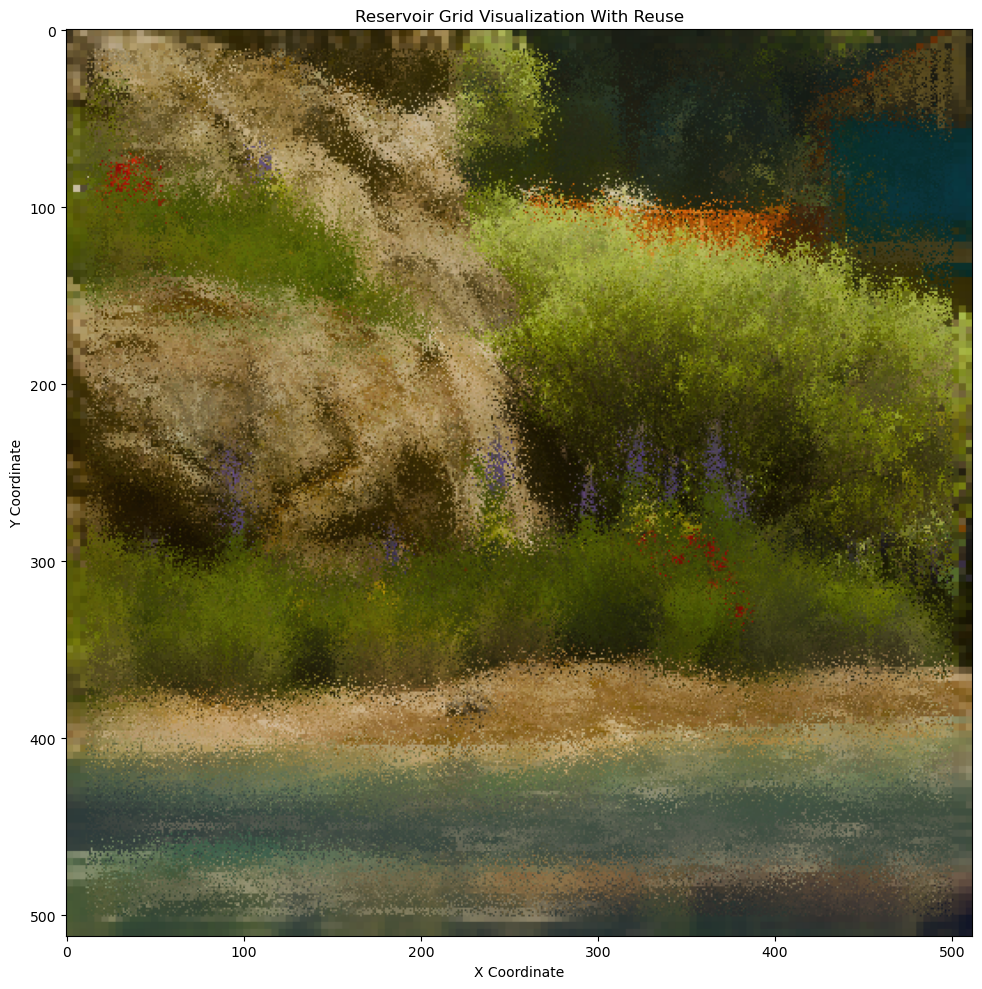

In [8]:
# This cell demonstrates spatial reuse
num_spatial_neighbours = 5 # 5 used in Bitterli 2020
spatial_reuse_radius = 10 # Bitterli uses 30, might really want to do the pooling size radius instead

# This will just be per pixel and implemented much differently in a shader
# The fastest Pythonic thing to do would be to do this on np arrays instead of pixel-by-pixel,
# but it's much easier to step through pixel-by-pixel

# Ignore edge pixels for now
reservoirs_spatial_reuse = [[initial_reservoirs[x][y] for y in range(width)] for x in range(height)]

for x in range(spatial_reuse_radius + 1, width - spatial_reuse_radius - 1):
	for y in range(spatial_reuse_radius + 1, height - spatial_reuse_radius - 1):

		for n in range(0, num_spatial_neighbours):
			neighbour_offset = (random.randint(-spatial_reuse_radius, spatial_reuse_radius), random.randint(-spatial_reuse_radius, spatial_reuse_radius))
			neighbour_reservoir = initial_reservoirs[x + neighbour_offset[0]][y + neighbour_offset[1]]
			reservoirs_spatial_reuse[x][y] = combine_reservoirs((x, y), 0.5, initial_reservoirs[x][y], neighbour_reservoir)


print(reservoirs_spatial_reuse[128][128].reservoir[0])


reservoir_spatial_reuse_array = np.array([[reservoir.reservoir[0] for reservoir in row] for row in reservoirs_spatial_reuse])
reservoir_spatial_reuse_array = cv2.cvtColor(reservoir_spatial_reuse_array, cv2.COLOR_BGR2RGB)

# Create the visualization
plt.figure(figsize=(10, 10))
plt.imshow(reservoir_spatial_reuse_array)
plt.title('Reservoir Grid Visualization With Reuse')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.tight_layout()
plt.show()
